In [1]:
import numpy as np
from scipy.stats import skewnorm
import random

class Patient():
    '''
    Simulate the mental state of a patient with bipolar disorder
    using Markov chain, each time step is one week.
    '''
    def __init__(self, std=0.01, p_relapse=0.01, p_recovery=0.2, init_prob=None, matrix=None):
        '''
        Inputs:

            std (float) The standard deviation when sampling noise from a distribution.
              Default: 0.01.

            p_relapse (float) The probability of relapse after recovery at each
              time step (one week), i.e. the probability that state 0 at time t
              will move to another state at time t+1. Default: 0.01.

            p_recovery (float) The probability of recovery if transitioning 
              to state 0 during cycling. Default: 0.2.
              
            init_prob (list) The probability of the initial state. We assume that
              we never start from state 0. Default: None
              
            matrix (dict) The transition matrix in the form of a dict. Each key
              has a list containing probability transitioning to another state.
              The possible states are -2, -1, 1, 2, and 0, in that order, but
              probability to transition to state 0 is implied to be the complement
              of the other probabilities. Default: None.
              '''
        if matrix:
            self.matrix = matrix
        else:
            self.matrix = {-2: [0.93, 0, 0.004, 0.004], 
                           -1: [0, 0.835, 0.017, 0.028],
                           1: [0.04, 0.065, 0.67, 0],
                           2: [0.011, 0.011, 0, 0.855]}
        self.std = std
        self.p_relapse = p_relapse
        self.p_recovery = p_recovery
        # Randomize initial state
        if init_prob:
            self.init_prob = init_prob
        else:
            self.init_prob = [0.38, 0.19, 0.17, 0.26]
        self.state = np.random.choice([-2, -1, 1, 2], p=self.init_prob)
        self.length = 0 # length of an episode
        self.path = [] # list to record changing mental states in an episode
        self.episodes = [] # list to record lengths of all episodes in this simulation
        self.episode_type = [] # list to record type of all episodes in this simulation
    
    def sample_prob(self, mean, mu=None, skewedness=2):
        """Add noise to the probability by sampling from a skewed distribution"""
        # Because the desired distribution is heavily skewed right,
        # we also sample the noise from a distribution that is skewed right
        if mu:
            return skewnorm.rvs(skewedness, loc=mean, scale=min(self.std, mu))
        else:
            return skewnorm.rvs(skewedness, loc=mean, scale=self.std)
    
    def update(self, reroll=True):
        """Update the state of the patient"""
        # Get the transition probabilities for this state
        transition = self.matrix[self.state]
        cumsum = np.cumsum(transition)
        p = random.random()
        if p < self.sample_prob(cumsum[0], transition[0]):
            self.state = -2
        elif p < self.sample_prob(cumsum[1], transition[1]):
            self.state = -1
        elif p < self.sample_prob(cumsum[2], transition[2]):
            self.state = 1
        elif p < self.sample_prob(cumsum[3], transition[3]):
            self.state = 2
        # If the type of the episode is 4 or 5 (cycling), then there is a chance
        # to get another "roll"
        elif self.check_type() > 3 and reroll and random.random() > self.sample_prob(self.p_recovery):
            self.update(False)
        else:
          # An episode ends only if the person experiences at least 8 consecutive weeks
          # with no symptoms
            count = 0
          # Go for 8 weeks, each with a chance of relapse
            while count < 8 and random.random() > self.sample_prob(2*self.p_relapse):
                count += 1
          # If the while loop ends on 8 weeks, then the episode ends and the person 
          # has recovered
            if count >= 8: 
                self.state = 0
          # If the while loop ends early, it means they relapsed. Return to their
          # most recent state and add the weeks advanced to length of episode
            else:
                self.length += count
   
    def simulate_single(self):
        """Simulate a single episode"""
        while self.state != 0:
            self.length += 1
            self.path.append(self.state)
            self.update()
      
    def simulate(self, steps):
        """Simulate for a desired amount of time"""
        count = 0
        while count < steps:
            count += 1
            # If having symptoms, then follow the same steps in the single episode simulation
            if self.state != 0:
                self.length += 1
                self.path.append(self.state)
                self.update()
            # If recovered:
            else:
                # Only count the episode if it lasts at least 2 weeks
                if self.length >= 2:
                    self.episodes.append(self.length)
                    self.episode_type.append(self.check_type())
                # Reset episode
                self.length = 0
                self.path = []
                # If the person relapse, re-initialize from beginning
                if random.random() < self.sample_prob(self.p_relapse):
                    self.state = np.random.choice([-2, -1, 1, 2], p=self.init_prob)
  
    def check_type(self):
        """Check the type of the episode"""
        # -1 if no episode
        if self.length == 0:
            return -1
        # Major depression (0) if the person has major depression (-2) throughout
        if all([x == -2 for x in self.path]):
            return 0
        # Minor depression (1) if the person has minor depression (-1) throughout
        if all([x == -1 for x in self.path]):
            return 1
        # Mania (2) if the person is manic (2) throughout
        if all([x == 2 for x in self.path]):
            return 2
        # Hypomania (3) if the person is hypomanic (1) throughout
        if all([x == 1 for x in self.path]):
            return 3
        # Minor cycling (4) if the person is swings between minor depression and hypomania
        if all([abs(x) == 1 for x in self.path]):
            return 4
        # Else, major cycling.
        return 5

In [2]:
import matplotlib.pyplot as plt
# Simulate single episodes
length_data = [] # Record length of all episodes
type_data = [] # Record type of episode
# Record length of episodes by type of episode
type_length = {0: [], 1: [], 2: [], 3: [], 4: [], 5: []}
for i in range(10000):
    sim = Patient()
    sim.simulate_single()
    # Only count the episode if it lasts at least 2 weeks
    if sim.length >= 2:
        length_data.append(sim.length)
        type_data.append(sim.check_type())
        type_length[sim.check_type()].append(sim.length)

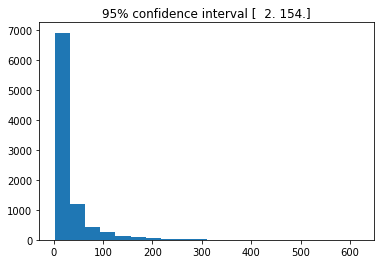

In [3]:
# Histogram of episode lengths
plt.hist(length_data, bins=20)
plt.title('95% confidence interval ' + str(np.percentile(length_data, [2.5, 97.5])))
plt.show()

Counter({0: 3131, 5: 2249, 2: 1679, 1: 1068, 3: 742, 4: 272})
Counter({0: 0.34252269992342194, 5: 0.24603435072749152, 2: 0.18367793458046167, 1: 0.11683623235969806, 3: 0.0811727382124494, 4: 0.02975604419647741})


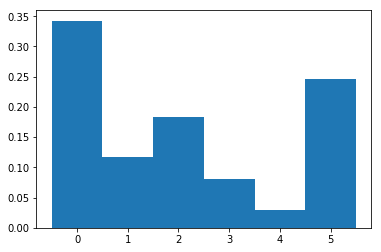

In [4]:
import collections
# Histogram of different types of moode episode
counter = collections.Counter(type_data)
# Print count for each type of episodes
print(counter)
labels, values = zip(*counter.items())
# Calculate and print proportion for each type of episodes 
for i in counter:
    counter[i] = counter[i]/len(type_data)
print(counter)
plt.bar(labels, [x/len(type_data) for x in values], 1)
plt.show()

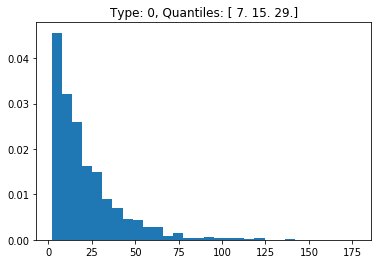

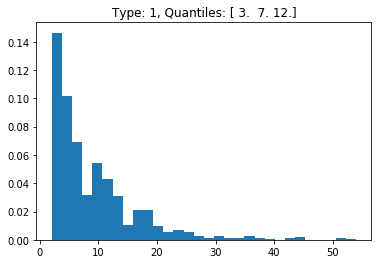

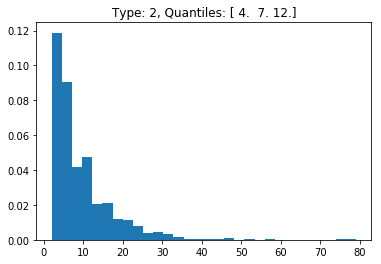

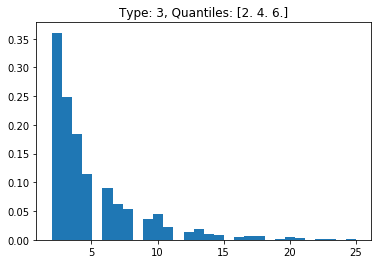

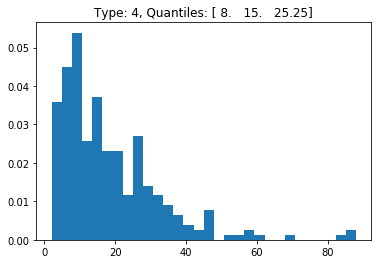

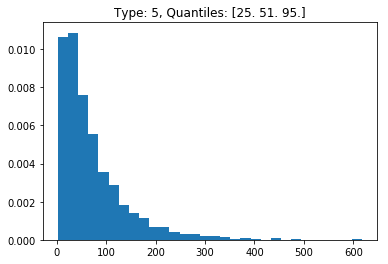

In [5]:
# Distribution of episode length for each type of mood episode
for i in type_length:
    data = type_length[i]
    plt.hist(data, bins=30, density=True)
    plt.title('Type: ' + str(i) + ', Quantiles: '+ str(np.percentile(data, [25, 50, 75])))
    plt.show()

Counter({3: 2843, 4: 2247, 2: 2158, 5: 1255, 1: 784, 6: 455, 7: 138, 8: 39, 9: 4, 11: 1})
Patients omitted:  76


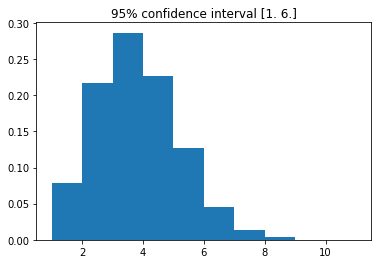

In [6]:
# Simulate multiple patients over the course of 5 years
data = []
for i in range(10000):
    sim = Patient()
    sim.simulate(52*5)
    # Don't count people who have no episode or didn't finish
    # their first episode
    if len(sim.episodes) > 0:
        data.append(len(sim.episodes))
counter=collections.Counter(data)
print(counter)
print("Patients omitted: ", 10000-len(data))
# Histogram of number of episodes
plt.hist(data, density=True)
plt.title('95% confidence interval ' + str(np.percentile(data, [2.5, 97.5])))
plt.show()

## Increase standard deviation

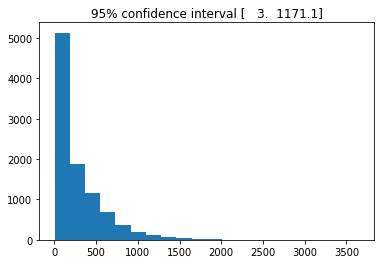

In [7]:
# Simulate single episodes
length_data = [] # Record length of all episodes
type_data = [] # Record type of episode
# Record length of episodes by type of episode
type_length = {0: [], 1: [], 2: [], 3: [], 4: [], 5: []}
for i in range(10000):
    sim = Patient(std=0.1)
    sim.simulate_single()
    if sim.length >= 2:
        length_data.append(sim.length)
        type_data.append(sim.check_type())
        type_length[sim.check_type()].append(sim.length)

plt.hist(length_data, bins=20)
plt.title('95% confidence interval ' + str(np.percentile(length_data, [2.5, 97.5])))
plt.show()

Counter({5: 7850, 0: 597, 2: 522, 1: 430, 3: 270, 4: 88})
Counter({5: 0.8045505790714359, 0: 0.0611868402172799, 2: 0.05350005124525981, 1: 0.04407092343958184, 3: 0.02767244029927232, 4: 0.009019165727170236})


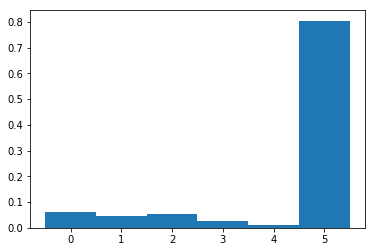

In [8]:
counter=collections.Counter(type_data)
print(counter)
labels, values = zip(*counter.items())
for i in counter:
    counter[i] = counter[i]/len(type_data)
print(counter)
plt.bar(labels, [x/len(type_data) for x in values], 1)
plt.show()

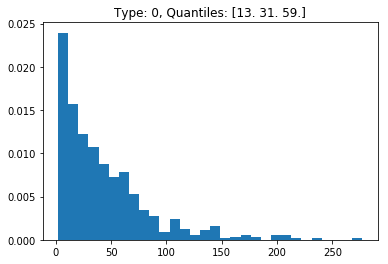

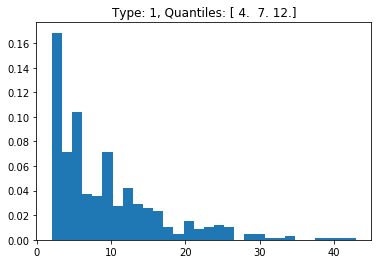

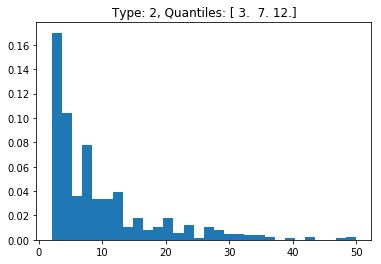

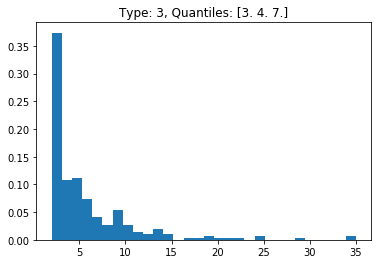

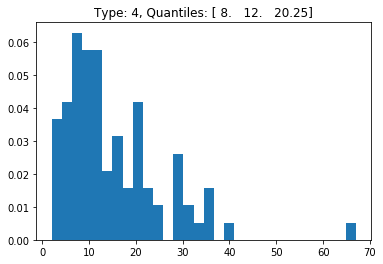

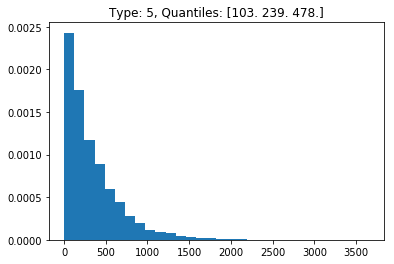

In [9]:
for i in type_length:
    data = type_length[i]
    plt.hist(data, bins=30, density=True)
    plt.title('Type: ' + str(i) + ', Quantiles: '+ str(np.percentile(data, [25, 50, 75])))
    plt.show()

Counter({1: 3226, 2: 1874, 3: 780, 4: 279, 5: 88, 6: 18, 7: 2})
Patients omitted:  3733


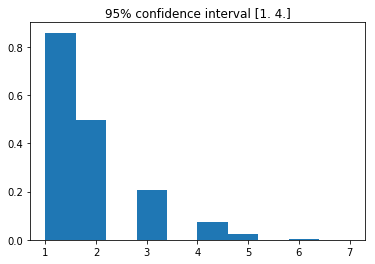

In [10]:
# Simulate multiple patients over the course of 5 years
data = []
for i in range(10000):
    sim = Patient(std=0.1)
    sim.simulate(52*5)
    # Don't count people who have no episode or didn't finish
    # their first episode
    if len(sim.episodes) > 0:
        data.append(len(sim.episodes))
counter=collections.Counter(data)
print(counter)
print("Patients omitted: ", 10000-len(data))
plt.hist(data, density=True)
plt.title('95% confidence interval ' + str(np.percentile(data, [2.5, 97.5])))
plt.show()

## Increase p_relapse

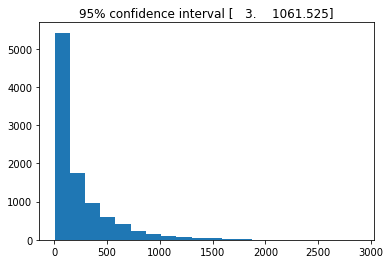

In [11]:
# Simulate single episodes
length_data = [] # Record length of all episodes
type_data = [] # Record type of episode
# Record length of episodes by type of episode
type_length = {0: [], 1: [], 2: [], 3: [], 4: [], 5: []}
for i in range(10000):
    sim = Patient(p_relapse=0.1)
    sim.simulate_single()
    if sim.length >= 2:
        length_data.append(sim.length)
        type_data.append(sim.check_type())
        type_length[sim.check_type()].append(sim.length)

plt.hist(length_data, bins=20)
plt.title('95% confidence interval ' + str(np.percentile(length_data, [2.5, 97.5])))
plt.show()

Counter({5: 5925, 0: 2145, 2: 869, 1: 428, 3: 323, 4: 144})
Counter({5: 0.6025015253203173, 0: 0.2181208053691275, 2: 0.0883668903803132, 1: 0.04352247305267439, 3: 0.032845230831808014, 4: 0.01464307504575961})


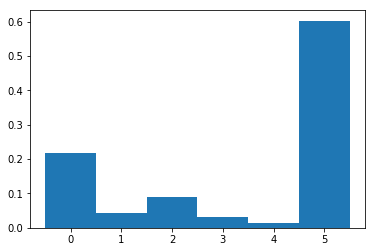

In [12]:
counter=collections.Counter(type_data)
print(counter)
labels, values = zip(*counter.items())
for i in counter:
    counter[i] = counter[i]/len(type_data)
print(counter)
plt.bar(labels, [x/len(type_data) for x in values], 1)
plt.show()

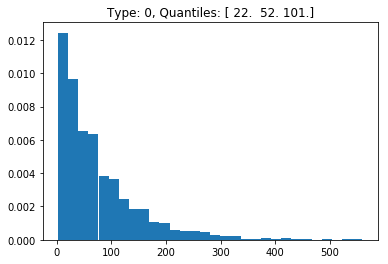

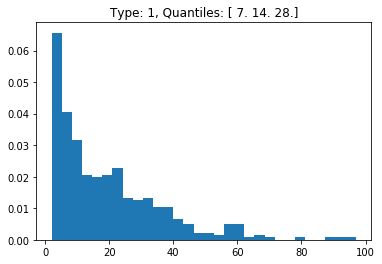

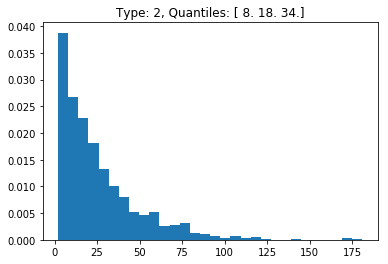

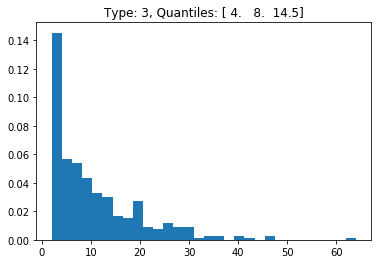

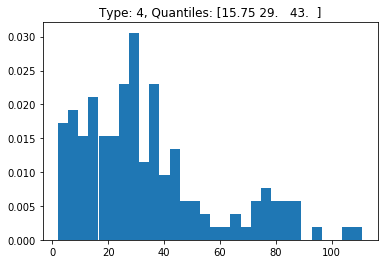

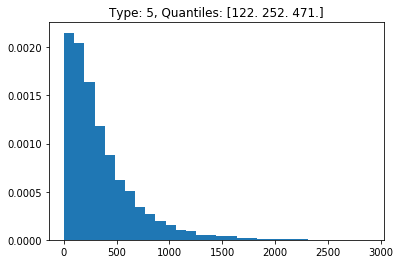

In [13]:
for i in type_length:
    data = type_length[i]
    plt.hist(data, bins=30, density=True)
    plt.title('Type: ' + str(i) + ', Quantiles: '+ str(np.percentile(data, [25, 50, 75])))
    plt.show()

Counter({1: 2946, 2: 2154, 3: 1190, 4: 564, 5: 193, 6: 54, 7: 16, 8: 4, 9: 2})
Patients omitted:  2877


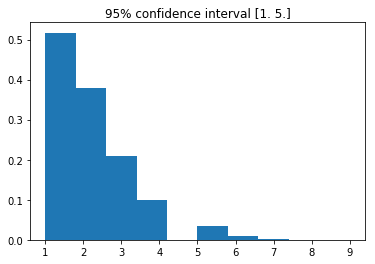

In [14]:
# Simulate multiple patients over the course of 5 years
data = []
for i in range(10000):
    sim = Patient(p_relapse=0.1)
    sim.simulate(52*5)
    # Don't count people who have no episode or didn't finish
    # their first episode
    if len(sim.episodes) > 0:
        data.append(len(sim.episodes))
counter=collections.Counter(data)
print(counter)
print("Patients omitted: ", 10000-len(data))
plt.hist(data, density=True)
plt.title('95% confidence interval ' + str(np.percentile(data, [2.5, 97.5])))
plt.show()

## Increase p_recovery

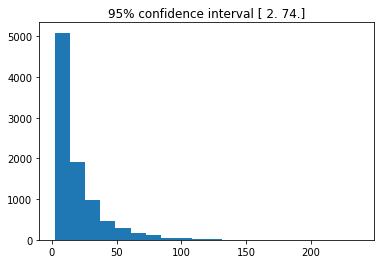

In [15]:
# Simulate single episodes
length_data = [] # Record length of all episodes
type_data = [] # Record type of episode
# Record length of episodes by type of episode
type_length = {0: [], 1: [], 2: [], 3: [], 4: [], 5: []}
for i in range(10000):
    sim = Patient(p_recovery=0.75)
    sim.simulate_single()
    if sim.length >= 2:
        length_data.append(sim.length)
        type_data.append(sim.check_type())
        type_length[sim.check_type()].append(sim.length)

plt.hist(length_data, bins=20)
plt.title('95% confidence interval ' + str(np.percentile(length_data, [2.5, 97.5])))
plt.show()

Counter({0: 3193, 5: 2108, 2: 1697, 1: 1020, 3: 708, 4: 432})
Counter({0: 0.34865691198951737, 5: 0.23018126228434155, 2: 0.18530246778772658, 1: 0.11137803013758463, 3: 0.07730945621314697, 4: 0.0471718715876829})


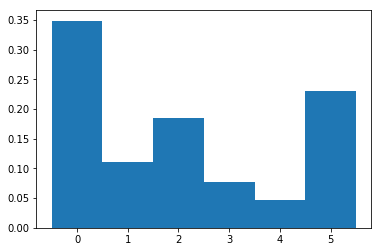

In [16]:
counter=collections.Counter(type_data)
print(counter)
labels, values = zip(*counter.items())
for i in counter:
    counter[i] = counter[i]/len(type_data)
print(counter)
plt.bar(labels, [x/len(type_data) for x in values], 1)
plt.show()

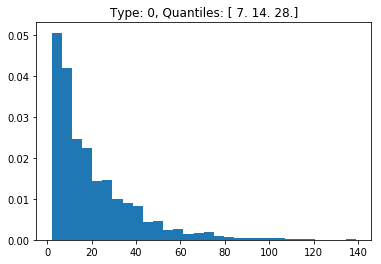

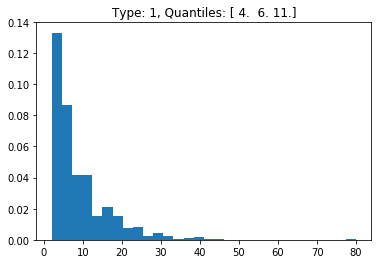

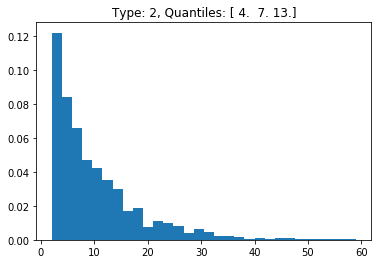

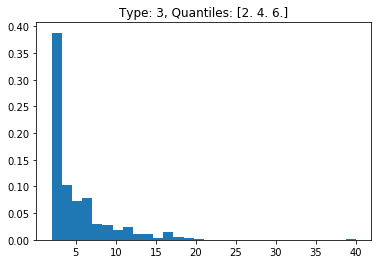

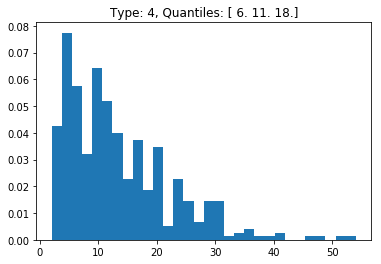

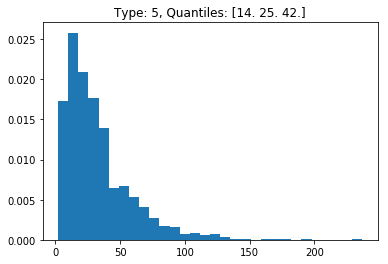

In [17]:
for i in type_length:
    data = type_length[i]
    plt.hist(data, bins=30, density=True)
    plt.title('Type: ' + str(i) + ', Quantiles: '+ str(np.percentile(data, [25, 50, 75])))
    plt.show()

Counter({3: 2716, 4: 2644, 5: 1646, 2: 1481, 6: 767, 1: 390, 7: 256, 8: 59, 9: 14, 10: 1, 11: 1})
Patients omitted:  25


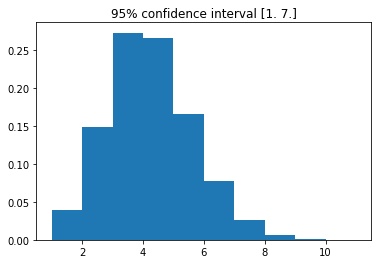

In [18]:
# Simulate multiple patients over the course of 5 years
data = []
for i in range(10000):
    sim = Patient(p_recovery=0.75)
    sim.simulate(52*5)
    # Don't count people who have no episode or didn't finish
    # their first episode
    if len(sim.episodes) > 0:
        data.append(len(sim.episodes))
counter=collections.Counter(data)
print(counter)
print("Patients omitted: ", 10000-len(data))
plt.hist(data, density=True)
plt.title('95% confidence interval ' + str(np.percentile(data, [2.5, 97.5])))
plt.show()

# Extension: Affective switch

In [25]:
class AffectiveSwitch(Patient):
    '''
    Simulate the mental state of a patient with bipolar disorder
    using Markov chain, each time step is one week.
    '''
    def __init__(self, p_switch=0.1, std=0.01, p_relapse=0.01, p_recovery=0.2, init_prob=None, matrix=None):
        '''
        Inputs:

            std (float) The standard deviation when sampling noise from a distribution.
              Default: 0.01.

            p_relapse (float) The probability of relapse after recovery at each
              time step (one week), i.e. the probability that state 0 at time t
              will move to another state at time t+1. Default: 0.01.

            p_recovery (float) The probability of recovery if not transitioning 
              to another state during cycling. Default: 0.2.

            init_prob (list) The probability of the initial state. We assume that
              we never start from state 0. Default: None

            matrix (dict) The transition matrix in the form of a dict. Each key
              has a list containing probability transitioning to another state.
              The possible states are -2, -1, 1, 2, and 0, in that order, but
              probability to transition to state 0 is implied to be the complement
              of the other probabilities. Default: None.

            p_switch (float) The probability of affective switch. Default: 0.5  
        '''
        Patient.__init__(self, std, p_relapse, p_recovery, init_prob, matrix)
        self.p_switch = p_switch
        self.anti_depressant()

    def anti_depressant(self):
        """This function simulates the effect on anti_depressant"""
        if self.state < 0:
            # Affective switch
            if random.random() < self.sample_prob(self.p_switch):
                if random.random() < 0.5:
                    self.state = 2
                else:
                    self.state = 1
            else:
                self.state = 0

    def simulate_single(self):
        """Simulate a single episode"""
        while self.state != 0:
            self.length += 1
            self.path.append(self.state)
            self.update()
            self.anti_depressant()

    def simulate(self, steps):
        """Simulate for a desired amount of time"""
        count = 0
        while count < steps:
            count += 1
            # If having symptoms, then follow the same steps in the single episode simulation
            if self.state != 0:
                self.length += 1
                self.path.append(self.state)
                self.update()
                self.anti_depressant()
            # If recovered:
            else:
                # Only count the episode if it lasts at least 2 weeks
                if self.length >= 2:
                    self.episodes.append(self.length)
                    self.episode_type.append(self.check_type())
                self.length = 0
                self.path = []
                # If the person relapse, re-initialize from beginning
                if random.random() < self.sample_prob(self.p_relapse):
                    self.state = np.random.choice([-2, -1, 1, 2], p=self.init_prob)
                    self.anti_depressant()

In [45]:
import matplotlib.pyplot as plt
# Simulate single episodes
length_data = [] # Record length of all episodes
type_data = [] # Record type of episode
# Record length of episodes by type of episode
type_length = {0: [], 1: [], 2: [], 3: [], 4: [], 5: []}
data = [] # Record number of episodes
for i in range(10000):
    sim = AffectiveSwitch()
    sim.simulate(52*5)
    if len(sim.episodes) > 0:
        data.append(len(sim.episodes))
        for ep in zip(sim.episode_type, sim.episodes):
            type_data.append(ep[0])
            length_data.append(ep[1])
            type_length[ep[0]].append(ep[1])

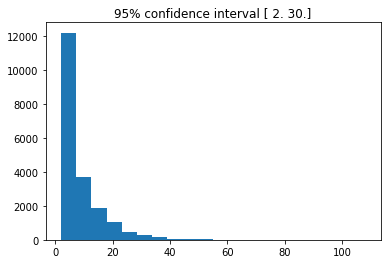

In [46]:
# Histogram of episode lengths
plt.hist(length_data, bins=20)
plt.title('95% confidence interval ' + str(np.percentile(length_data, [2.5, 97.5])))
plt.show()

Counter({2: 11893, 3: 7000, 5: 943})
Counter({2: 0.5995664448477516, 3: 0.35289372857430934, 5: 0.0475398265779391})


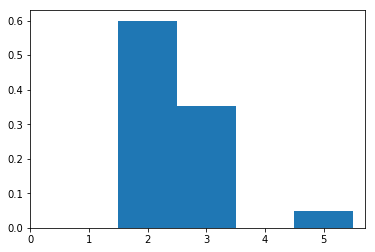

In [47]:
# Histogram of different types of mood episode
counter = collections.Counter(type_data)
print(counter)
labels, values = zip(*counter.items())
for i in counter:
    counter[i] = counter[i]/len(type_data)
print(counter)
plt.bar(labels, [x/len(type_data) for x in values], 1)
plt.xticks(range(6))
plt.show()

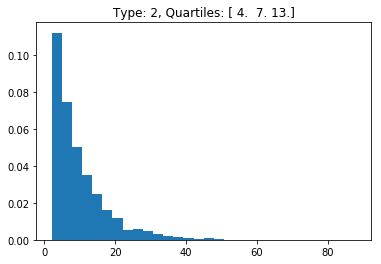

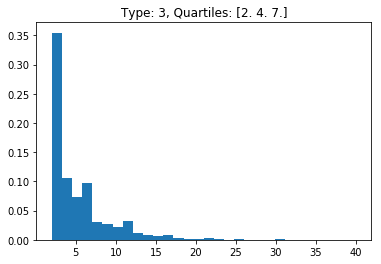

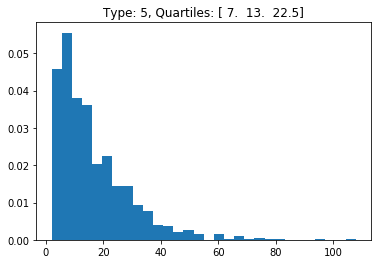

In [48]:
for i in type_length:
    if len(type_length[i]) > 0:
        data = type_length[i]
        plt.hist(data, bins=30, density=True)
        plt.title('Type: ' + str(i) + ', Quartiles: '+ str(np.percentile(data, [25, 50, 75])))
        plt.show()

{2: 0.6471062714256907, 3: 0.35289372857430934}


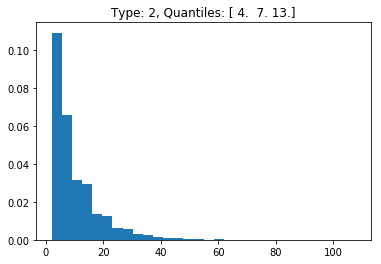

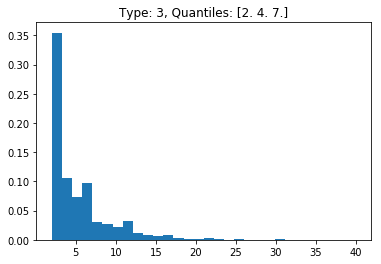

In [49]:
combined_type = {2: type_length[2] + type_length[5],
                3: type_length[3]}
print({2: counter[2] + counter[5], 3: counter[3]})
for i in combined_type:
    data = combined_type[i]
    plt.hist(data, bins=30, density=True)
    plt.title('Type: ' + str(i) + ', Quantiles: '+ str(np.percentile(data, [25, 50, 75])))
    plt.show()

Counter({2: 1815, 3: 1328, 4: 941, 5: 653, 6: 468, 7: 392, 8: 272, 9: 236, 10: 188, 11: 147, 12: 140, 13: 98, 14: 77, 15: 54, 16: 43, 17: 37, 18: 28, 21: 16, 20: 15, 19: 14, 22: 8, 25: 6, 23: 6, 30: 3, 27: 3, 29: 3, 26: 2, 24: 2, 31: 2, 40: 1, 28: 1, 36: 1})
Patients omitted:  3000


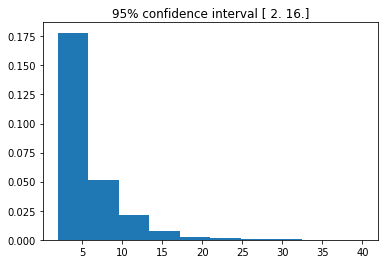

In [50]:
counter = collections.Counter(data)
print(counter)
print("Patients omitted: ", 10000-len(data))
# Histogram of number of recurrences
plt.hist(data, density=True)
plt.title('95% confidence interval ' + str(np.percentile(data, [2.5, 97.5])))
plt.show()